In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import string
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.stem.porter import PorterStemmer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping


In [2]:
df=pd.read_csv('/content/BBC News Train.csv')
print("Shpe of Data",df.shape)
df.head(10)

Shpe of Data (1490, 3)


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
5,1582,howard truanted to play snooker conservative...,politics
6,651,wales silent on grand slam talk rhys williams ...,sport
7,1797,french honour for director parker british film...,entertainment
8,2034,car giant hit by mercedes slump a slump in pro...,business
9,1866,fockers fuel festive film chart comedy meet th...,entertainment


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64


Text(0.5, 1.0, 'The Distribution of Category')

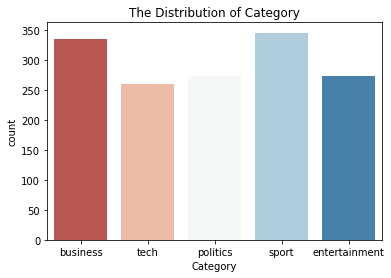

In [4]:
print(df['Category'].value_counts())
sns.countplot(data = df, x = "Category", palette = "RdBu")
plt.title("The Distribution of Category")

In [5]:
df.describe(include = 'object')


,Text,Category
count,1490,1490
unique,1440,5
top,microsoft seeking spyware trojan microsoft is ...,sport
freq,2,346


In [6]:
df['length'] = df['Text'].apply(len)


(array([919., 482.,  76.,   6.,   3.,   1.,   0.,   2.,   0.,   1.]),
 array([  501. ,  2289.6,  4078.2,  5866.8,  7655.4,  9444. , 11232.6,
        13021.2, 14809.8, 16598.4, 18387. ]),
 <a list of 10 Patch objects>)

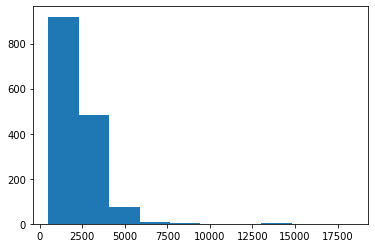

In [7]:
plt.hist(x=df['length'])

In [8]:
def get_polarity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    pol = textblob.sentiment.polarity
    return pol

# lets apply the function
df['polarity'] = df['Text'].apply(get_polarity)

In [9]:
def get_subjectivity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    subj = textblob.sentiment.subjectivity
    return subj

# lets apply the Function
df['subjectivity'] = df['Text'].apply(get_subjectivity)

In [10]:
df[['length','polarity','Text']]

,length,polarity,Text
0,1866,0.023320,worldcom ex-boss launches defence lawyers defe...
1,2016,0.077917,german business confidence slides german busin...
2,3104,0.077754,bbc poll indicates economic gloom citizens in ...
3,3618,0.156109,lifestyle governs mobile choice faster bett...
4,2190,0.009685,enron bosses in $168m payout eighteen former e...
...,...,...,...
1485,1266,0.107292,double eviction from big brother model caprice...
1486,3111,0.221375,dj double act revamp chart show dj duo jk and ...
1487,1370,0.066856,weak dollar hits reuters revenues at media gro...
1488,3242,0.203186,apple ipod family expands market apple has exp...


In [11]:
df[['length','polarity','subjectivity']]


,length,polarity,subjectivity
0,1866,0.023320,0.395125
1,2016,0.077917,0.353854
2,3104,0.077754,0.390688
3,3618,0.156109,0.478536
4,2190,0.009685,0.342117
...,...,...,...
1485,1266,0.107292,0.340278
1486,3111,0.221375,0.458355
1487,1370,0.066856,0.417992
1488,3242,0.203186,0.427091


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


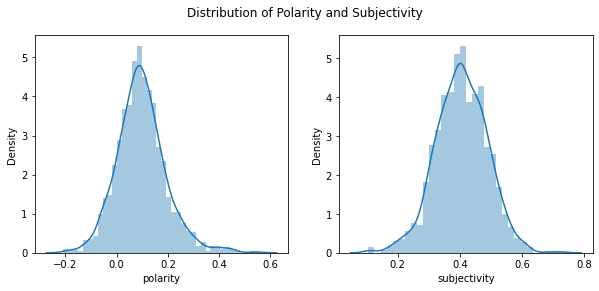

In [13]:
plt.rcParams['figure.figsize'] = (10, 4)

plt.subplot(1, 2, 1)
sns.distplot(df['polarity'])

plt.subplot(1, 2, 2)
sns.distplot(df['subjectivity'])

plt.suptitle('Distribution of Polarity and Subjectivity')
plt.show()

In [14]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df['Text'])
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

wordcloud = WordCloud(background_color = 'black', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))


In [15]:
df['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

In [16]:
num_of_categories = 45000
shuffled = df.reindex(np.random.permutation(df.index))
sport    = shuffled[shuffled['Category'] == 'sport'][:num_of_categories]
business = shuffled[shuffled['Category'] == 'business'][:num_of_categories]
politics = shuffled[shuffled['Category'] == 'politics'][:num_of_categories]
entertainment = shuffled[shuffled['Category'] == 'entertainment'][:num_of_categories]
tech = shuffled[shuffled['Category'] == 'tech'][:num_of_categories]
concated = pd.concat([sport,business,politics,entertainment,tech], ignore_index=True)
#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0

In [17]:
concated.loc[concated['Category'] == 'sport', 'LABEL'] = 0
concated.loc[concated['Category'] == 'business', 'LABEL'] = 1
concated.loc[concated['Category'] == 'politics', 'LABEL'] = 2
concated.loc[concated['Category'] == 'entertainment', 'LABEL'] = 3
concated.loc[concated['Category'] == 'tech', 'LABEL'] = 4
print(concated['LABEL'][:10])
labels = to_categorical(concated['LABEL'], num_classes=5)
print(labels[:10])
if 'Category' in concated.keys():
    concated.drop(['Category'], axis=1)

1118    3
410     1
957     3
220     0
309     0
280     0
1281    4
252     0
126     0
652     1
Name: LABEL, dtype: int64
[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [18]:
n_most_common_words = 8000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(concated['Text'].values)
sequences = tokenizer.texts_to_sequences(concated['Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)


Found 24983 unique tokens.


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [20]:
epochs = 50
emb_dim = 128
batch_size = 64
labels[:2]

array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [21]:
model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(5, activation='softmax'))

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])


In [23]:
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 128)          1024000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 130, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 1,073,733
Trainable params: 1,073,733
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.01)])

Epoch 1/50
14/14 [==============================] - 15s 552ms/step - loss: 1.6079 - acc: 0.2251 - val_loss: 1.6014 - val_acc: 0.2902
Epoch 2/50
14/14 [==============================] - 10s 695ms/step - loss: 1.5972 - acc: 0.2811 - val_loss: 1.5941 - val_acc: 0.2812
Epoch 3/50
14/14 [==============================] - 8s 587ms/step - loss: 1.5836 - acc: 0.3180 - val_loss: 1.5760 - val_acc: 0.4062
Epoch 4/50
14/14 [==============================] - 7s 507ms/step - loss: 1.5002 - acc: 0.3639 - val_loss: 1.4398 - val_acc: 0.3973
Epoch 5/50
14/14 [==============================] - 7s 521ms/step - loss: 1.3526 - acc: 0.4356 - val_loss: 1.2698 - val_acc: 0.4554
Epoch 6/50
14/14 [==============================] - 7s 506ms/step - loss: 1.2100 - acc: 0.4569 - val_loss: 1.2099 - val_acc: 0.4598
Epoch 7/50
14/14 [==============================] - 7s 510ms/step - loss: 1.1214 - acc: 0.4714 - val_loss: 1.1077 - val_acc: 0.5045
Epoch 8/50
14/14 [==============================] - 7s 517ms/step - loss: 

In [25]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

12/12 [==============================] - 0s 36ms/step - loss: 0.6203 - acc: 0.8418
Test set
  Loss: 0.620
  Accuracy: 0.842


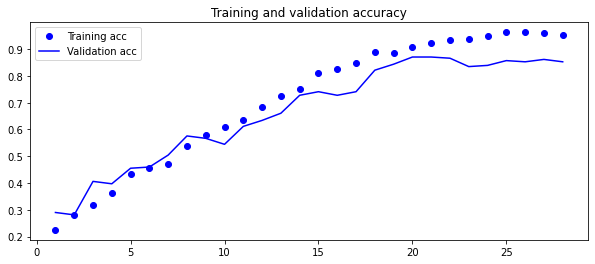

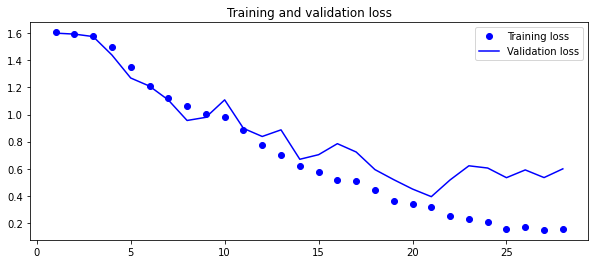

In [27]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
txt = ["Rafael Nadal extended his Grand Slam winning streak to 19 matches with a 3-6, 7-5, 3-6, 7-5, 7-6 (10-4) victory over Taylor Fritz"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['sport','business','politics','entertainment','tech']
print(pred, labels[np.argmax(pred)])

[[0.5625312  0.08127648 0.05344354 0.10503899 0.1977098 ]] sport


In [36]:
txt = ["Twitter challenges Indian orders to block content: reports"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['sport','business','politics','entertainment','tech']
print(pred, labels[np.argmax(pred)])

[[0.01174695 0.12352376 0.009678   0.00559408 0.8494572 ]] tech


In [37]:
model.save("topic_classifcation.h5")